In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models


import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 20141, done.
remote: Counting objects: 100% (1961/1961), done.
remote: Compressing objects: 100% (1055/1055), done.
remote: Total 20141 (delta 909), reused 1584 (delta 595), pack-reused 18180
Receiving objects: 100% (20141/20141), 33.15 MiB | 27.93 MiB/s, done.
Resolving deltas: 100% (11003/11003), done.


In [3]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [4]:
# Download data and extract it to folder
get_data_extract()

4996292608/4996278331 [==============================] - 205s 0us/step
Dataset downloaded and extracted!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Understand dataset structure and files 

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [6]:
# Check the extracted dataset folder
os.listdir('food-101/')

['README.txt', 'license_agreement.txt', 'images', 'meta']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [7]:
os.listdir('food-101/images')

['deviled_eggs',
 'baklava',
 'bruschetta',
 'beef_carpaccio',
 'spaghetti_carbonara',
 'macaroni_and_cheese',
 'crab_cakes',
 'oysters',
 'pancakes',
 'spring_rolls',
 'french_toast',
 'ice_cream',
 'mussels',
 'eggs_benedict',
 'caesar_salad',
 'croque_madame',
 'fish_and_chips',
 'baby_back_ribs',
 'breakfast_burrito',
 'lasagna',
 'chocolate_mousse',
 'filet_mignon',
 'caprese_salad',
 'gyoza',
 'gnocchi',
 'chicken_wings',
 'huevos_rancheros',
 'club_sandwich',
 'beef_tartare',
 'tacos',
 'foie_gras',
 'cheesecake',
 'dumplings',
 'chicken_quesadilla',
 'scallops',
 'cheese_plate',
 'pulled_pork_sandwich',
 'paella',
 'macarons',
 'takoyaki',
 'prime_rib',
 'garlic_bread',
 'panna_cotta',
 'donuts',
 'churros',
 'falafel',
 'edamame',
 'strawberry_shortcake',
 'hot_and_sour_soup',
 'frozen_yogurt',
 'escargots',
 'cup_cakes',
 'red_velvet_cake',
 'pho',
 'fried_rice',
 'risotto',
 'waffles',
 'peking_duck',
 'tiramisu',
 'ceviche',
 'beet_salad',
 'bibimbap',
 'apple_pie',
 'lobst

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [8]:
os.listdir('food-101/meta')

['classes.txt',
 'test.json',
 'labels.txt',
 'train.txt',
 'train.json',
 'test.txt']

# Visualize random image from each of the 101 classes

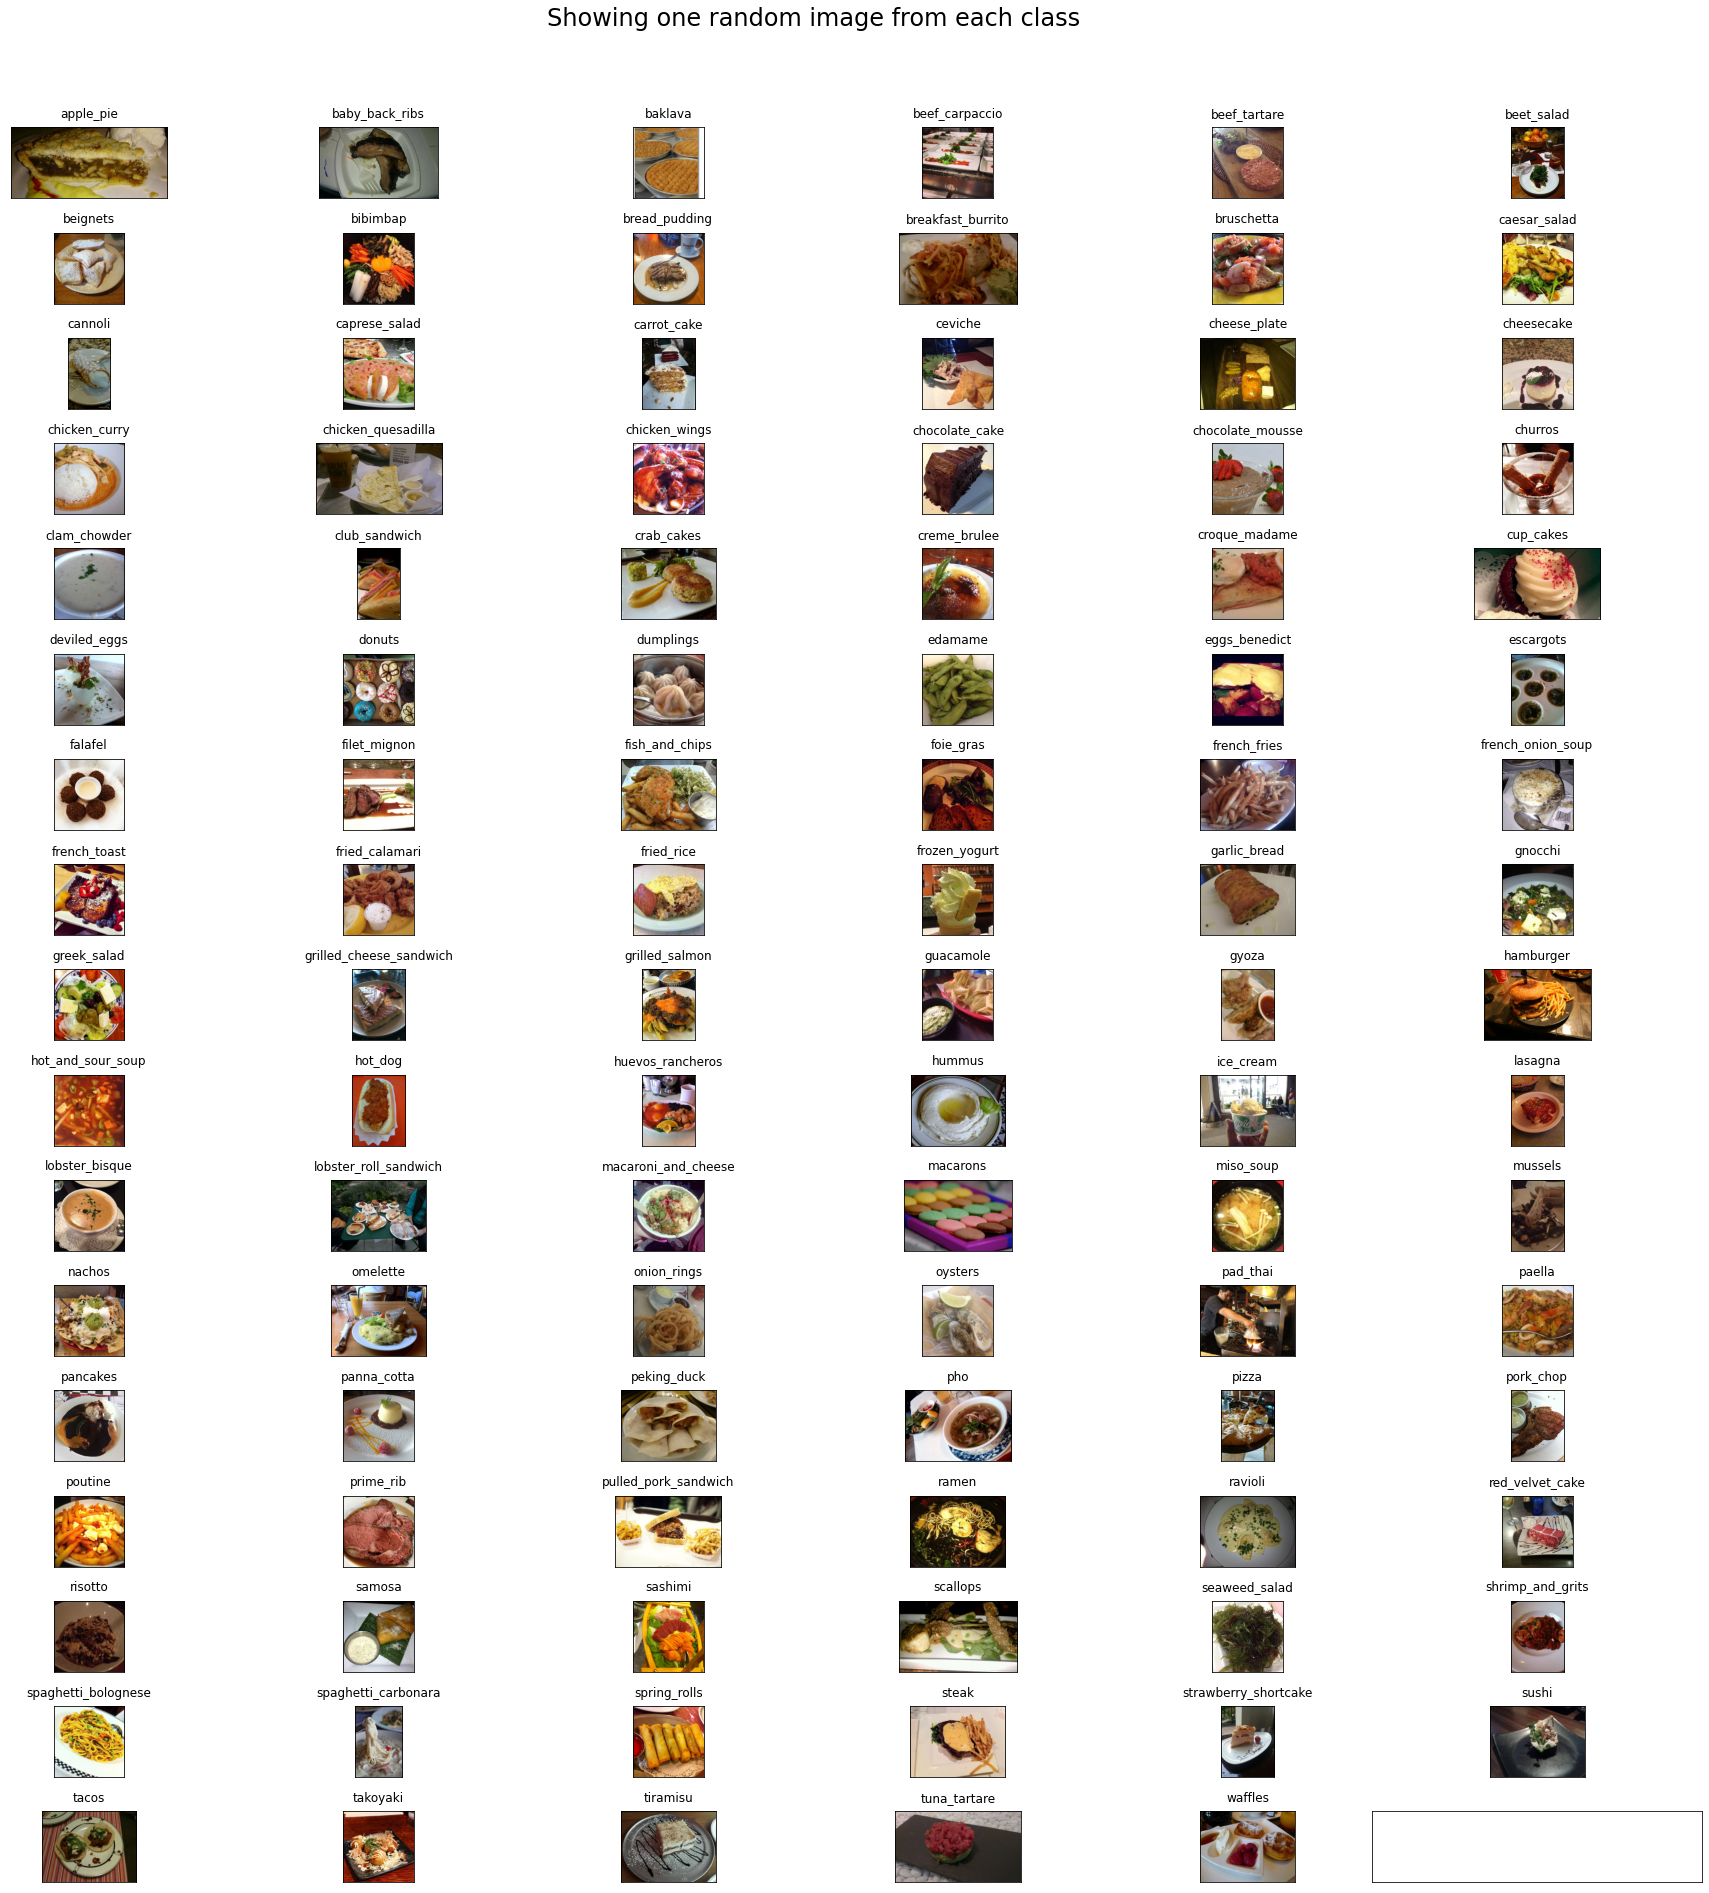

In [9]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [10]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [11]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [12]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [13]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [14]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (10)

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 10 classes  

In [15]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [16]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [17]:
# picking 10 food items and generating separate data folders for the same
food_list = ['deviled_eggs','beef_tartare','hot_dog','lobster_bisque','sushi','tuna_tartare','fried_rice','samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [18]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into deviled_eggs
Copying images into beef_tartare
Copying images into hot_dog
Copying images into lobster_bisque
Copying images into sushi
Copying images into tuna_tartare
Copying images into fried_rice
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [19]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [20]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into deviled_eggs
Copying images into beef_tartare
Copying images into hot_dog
Copying images into lobster_bisque
Copying images into sushi
Copying images into tuna_tartare
Copying images into fried_rice
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [21]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


In [22]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


## **preparing data for traning**

In [23]:
n_classes = 10
nb_train_samples = train_files
nb_validation_samples = test_files
K.clear_session()
img_width, img_height = 128, 128
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
batch_size = 16
bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
history_path = 'history_'+str(n_classes)+'.log'

train_datagen = ImageDataGenerator(
    preprocessing_function=None,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=None)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## **2 Layer classifier**

In [ ]:
def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

Epoch 1/10
468/468 [==============================] - 112s 211ms/step - loss: 1.2667 - accuracy: 0.6227 - val_loss: 0.7135 - val_accuracy: 0.7724
Epoch 2/10
468/468 [==============================] - 94s 200ms/step - loss: 0.8366 - accuracy: 0.7254 - val_loss: 0.5856 - val_accuracy: 0.8029
Epoch 3/10
468/468 [==============================] - 95s 203ms/step - loss: 0.7175 - accuracy: 0.7622 - val_loss: 0.6920 - val_accuracy: 0.7744
Epoch 4/10
468/468 [==============================] - 95s 203ms/step - loss: 0.6437 - accuracy: 0.7839 - val_loss: 0.6246 - val_accuracy: 0.7969
Epoch 5/10
468/468 [==============================] - 94s 201ms/step - loss: 0.6145 - accuracy: 0.7958 - val_loss: 0.5767 - val_accuracy: 0.8197
Epoch 6/10
468/468 [==============================] - 93s 198ms/step - loss: 0.5686 - accuracy: 0.8059 - val_loss: 0.5904 - val_accuracy: 0.8133
Epoch 7/10
468/468 [==============================] - 93s 199ms/step - loss: 0.5395 - accuracy: 0.8124 - val_loss: 0.6261 - val_a

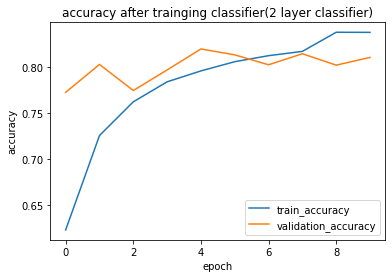

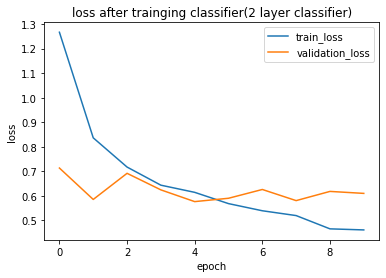

In [ ]:
plot_accuracy(history,'accuracy after trainging classifier(2 layer classifier)')

plot_loss(history,'loss after trainging classifier(2 layer classifier)')

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False



Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )


Epoch 10/20
468/468 [==============================] - 109s 207ms/step - loss: 0.4189 - accuracy: 0.8574 - val_loss: 0.6169 - val_accuracy: 0.8173
Epoch 11/20
468/468 [==============================] - 95s 202ms/step - loss: 0.3098 - accuracy: 0.8895 - val_loss: 0.5833 - val_accuracy: 0.8261
Epoch 12/20
468/468 [==============================] - 95s 203ms/step - loss: 0.2601 - accuracy: 0.9134 - val_loss: 0.5984 - val_accuracy: 0.8305
Epoch 13/20
468/468 [==============================] - 95s 202ms/step - loss: 0.2317 - accuracy: 0.9178 - val_loss: 0.5710 - val_accuracy: 0.8337
Epoch 14/20
468/468 [==============================] - 93s 198ms/step - loss: 0.1863 - accuracy: 0.9403 - val_loss: 0.5726 - val_accuracy: 0.8337
Epoch 15/20
468/468 [==============================] - 94s 200ms/step - loss: 0.1785 - accuracy: 0.9415 - val_loss: 0.5829 - val_accuracy: 0.8353
Epoch 16/20
468/468 [==============================] - 94s 201ms/step - loss: 0.1639 - accuracy: 0.9435 - val_loss: 0.6098 

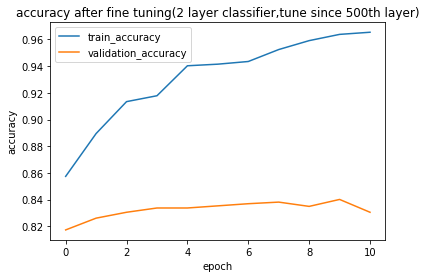

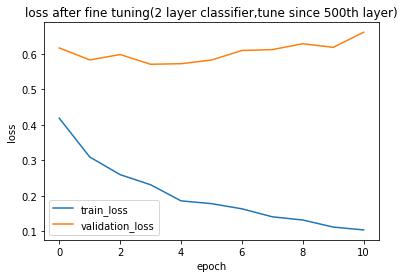

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(2 layer classifier,tune since 500th layer)')

plot_loss(history_fine,'loss after fine tuning(2 layer classifier,tune since 500th layer)')

## **3 layer classifier**

In [ ]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(512,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

Epoch 1/10
468/468 [==============================] - 114s 211ms/step - loss: 1.3184 - accuracy: 0.5826 - val_loss: 0.6303 - val_accuracy: 0.7817
Epoch 2/10
468/468 [==============================] - 93s 198ms/step - loss: 0.9336 - accuracy: 0.6940 - val_loss: 0.5936 - val_accuracy: 0.7933
Epoch 3/10
468/468 [==============================] - 94s 201ms/step - loss: 0.8301 - accuracy: 0.7229 - val_loss: 0.5746 - val_accuracy: 0.8053
Epoch 4/10
468/468 [==============================] - 93s 199ms/step - loss: 0.7561 - accuracy: 0.7418 - val_loss: 0.5726 - val_accuracy: 0.8077
Epoch 5/10
468/468 [==============================] - 92s 197ms/step - loss: 0.7194 - accuracy: 0.7577 - val_loss: 0.5729 - val_accuracy: 0.8121
Epoch 6/10
468/468 [==============================] - 94s 200ms/step - loss: 0.6740 - accuracy: 0.7720 - val_loss: 0.5531 - val_accuracy: 0.8161
Epoch 7/10
468/468 [==============================] - 94s 200ms/step - loss: 0.6215 - accuracy: 0.7906 - val_loss: 0.5552 - val_a

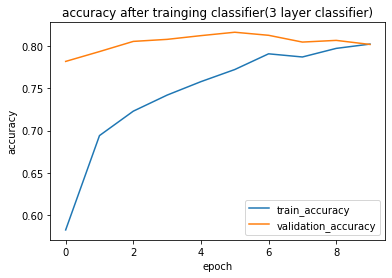

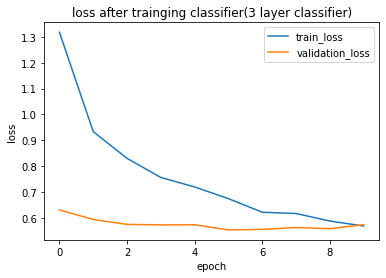

In [ ]:
plot_accuracy(history,'accuracy after trainging classifier(3 layer classifier)')

plot_loss(history,'loss after trainging classifier(3 layer classifier)')

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 111s 210ms/step - loss: 0.5140 - accuracy: 0.8288 - val_loss: 0.5481 - val_accuracy: 0.8201
Epoch 11/20
468/468 [==============================] - 94s 201ms/step - loss: 0.4261 - accuracy: 0.8546 - val_loss: 0.5167 - val_accuracy: 0.8321
Epoch 12/20
468/468 [==============================] - 93s 200ms/step - loss: 0.3606 - accuracy: 0.8804 - val_loss: 0.5118 - val_accuracy: 0.8329
Epoch 13/20
468/468 [==============================] - 94s 201ms/step - loss: 0.3187 - accuracy: 0.8924 - val_loss: 0.5086 - val_accuracy: 0.8321
Epoch 14/20
468/468 [==============================] - 95s 202ms/step - loss: 0.2789 - accuracy: 0.9049 - val_loss: 0.5475 - val_accuracy: 0.8245
Epoch 15/20
468/468 [==============================] - 95s 204ms/step - loss: 0.2478 - accuracy: 0.9177 - val_loss: 0.5434 - val_accuracy: 0.8345
Epoch 16/20
468/468 [==============================] - 96s 205ms/step - loss: 0.2334 - accuracy: 0.9205 - val_loss: 0.5396 

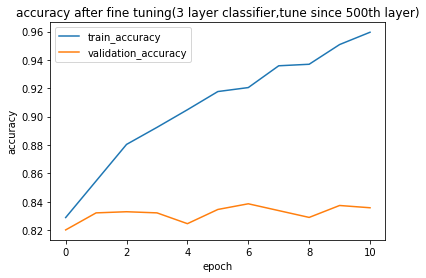

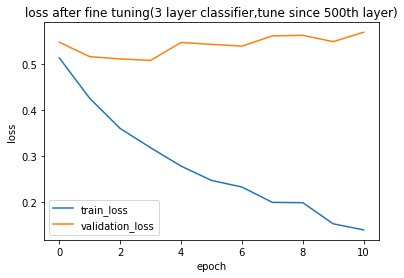

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(3 layer classifier,tune since 500th layer)')

plot_loss(history_fine,'loss after fine tuning(3 layer classifier,tune since 500th layer)')

## **5 Layers Classifier**

In [ ]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(512,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(64,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

Epoch 1/10
468/468 [==============================] - 114s 214ms/step - loss: 2.0729 - accuracy: 0.3014 - val_loss: 1.0682 - val_accuracy: 0.7087
Epoch 2/10
468/468 [==============================] - 95s 203ms/step - loss: 1.5869 - accuracy: 0.4824 - val_loss: 0.8068 - val_accuracy: 0.7628
Epoch 3/10
468/468 [==============================] - 96s 204ms/step - loss: 1.4177 - accuracy: 0.5323 - val_loss: 0.7244 - val_accuracy: 0.7556
Epoch 4/10
468/468 [==============================] - 93s 199ms/step - loss: 1.3175 - accuracy: 0.5715 - val_loss: 0.6712 - val_accuracy: 0.7720
Epoch 5/10
468/468 [==============================] - 95s 202ms/step - loss: 1.2659 - accuracy: 0.5870 - val_loss: 0.6640 - val_accuracy: 0.7724
Epoch 6/10
468/468 [==============================] - 95s 204ms/step - loss: 1.2107 - accuracy: 0.6154 - val_loss: 0.6491 - val_accuracy: 0.7784
Epoch 7/10
468/468 [==============================] - 98s 209ms/step - loss: 1.1765 - accuracy: 0.6267 - val_loss: 0.6245 - val_a

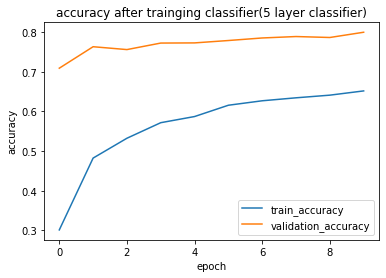

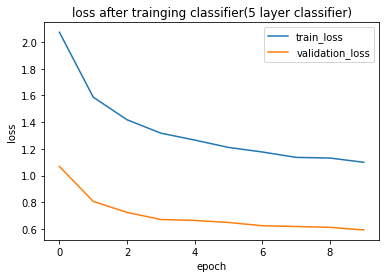

In [ ]:
plot_accuracy(history,'accuracy after trainging classifier(5 layer classifier)')

plot_loss(history,'loss after trainging classifier(5 layer classifier)')

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 117s 219ms/step - loss: 1.0614 - accuracy: 0.6638 - val_loss: 0.5795 - val_accuracy: 0.8081
Epoch 11/20
468/468 [==============================] - 100s 213ms/step - loss: 0.9713 - accuracy: 0.6901 - val_loss: 0.5706 - val_accuracy: 0.8037
Epoch 12/20
468/468 [==============================] - 100s 213ms/step - loss: 0.9565 - accuracy: 0.7018 - val_loss: 0.5371 - val_accuracy: 0.8081
Epoch 13/20
468/468 [==============================] - 99s 211ms/step - loss: 0.8918 - accuracy: 0.7210 - val_loss: 0.5481 - val_accuracy: 0.8117
Epoch 14/20
468/468 [==============================] - 98s 210ms/step - loss: 0.8517 - accuracy: 0.7245 - val_loss: 0.5495 - val_accuracy: 0.8161
Epoch 15/20
468/468 [==============================] - 97s 207ms/step - loss: 0.8243 - accuracy: 0.7402 - val_loss: 0.5306 - val_accuracy: 0.8117
Epoch 16/20
468/468 [==============================] - 97s 208ms/step - loss: 0.8240 - accuracy: 0.7413 - val_loss: 0.540

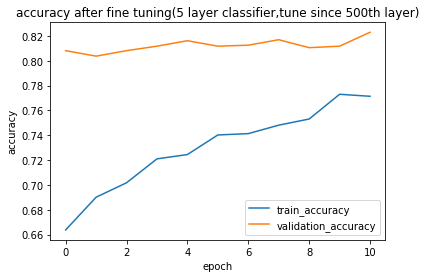

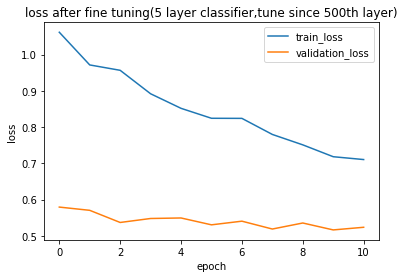

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(5 layer classifier,tune since 500th layer)')

plot_loss(history_fine,'loss after fine tuning(5 layer classifier,tune since 500th layer)')

## **As you can see,three layer is the best**

#### **Now Divide the number of neurons in each layer by 2 in selected architecture that consists classifier with three layers**

## **Divid by 2**

In [ ]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(512,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

51888128/51877672 [==============================] - 1s 0us/step
Epoch 1/10
468/468 [==============================] - 108s 199ms/step - loss: 1.3247 - accuracy: 0.5637 - val_loss: 0.6181 - val_accuracy: 0.7857
Epoch 2/10
468/468 [==============================] - 94s 201ms/step - loss: 0.9900 - accuracy: 0.6673 - val_loss: 0.5567 - val_accuracy: 0.8045
Epoch 3/10
468/468 [==============================] - 94s 200ms/step - loss: 0.8829 - accuracy: 0.7006 - val_loss: 0.5414 - val_accuracy: 0.8125
Epoch 4/10
468/468 [==============================] - 95s 203ms/step - loss: 0.8292 - accuracy: 0.7183 - val_loss: 0.5465 - val_accuracy: 0.8137
Epoch 5/10
468/468 [==============================] - 91s 194ms/step - loss: 0.7614 - accuracy: 0.7464 - val_loss: 0.5244 - val_accuracy: 0.8217
Epoch 6/10
468/468 [==============================] - 91s 193ms/step - loss: 0.7365 - accuracy: 0.7532 - val_loss: 0.5256 - val_accuracy: 0.8169
Epoch 7/10
468/468 [==============================] - 91s 195ms/

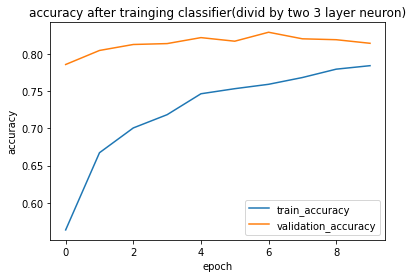

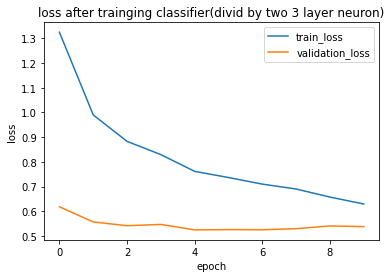

In [ ]:
plot_accuracy(history,'accuracy after trainging classifier(divid by two 3 layer neuron)')

plot_loss(history,'loss after trainging classifier(divid by two 3 layer neuron)')

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 113s 210ms/step - loss: 0.6000 - accuracy: 0.7989 - val_loss: 0.5068 - val_accuracy: 0.8257
Epoch 11/20
468/468 [==============================] - 95s 204ms/step - loss: 0.5032 - accuracy: 0.8295 - val_loss: 0.4913 - val_accuracy: 0.8333
Epoch 12/20
468/468 [==============================] - 93s 200ms/step - loss: 0.4433 - accuracy: 0.8493 - val_loss: 0.4769 - val_accuracy: 0.8413
Epoch 13/20
468/468 [==============================] - 93s 199ms/step - loss: 0.3829 - accuracy: 0.8720 - val_loss: 0.4807 - val_accuracy: 0.8353
Epoch 14/20
468/468 [==============================] - 91s 195ms/step - loss: 0.3523 - accuracy: 0.8821 - val_loss: 0.4773 - val_accuracy: 0.8397
Epoch 15/20
468/468 [==============================] - 93s 198ms/step - loss: 0.3113 - accuracy: 0.8976 - val_loss: 0.4887 - val_accuracy: 0.8405
Epoch 16/20
468/468 [==============================] - 93s 198ms/step - loss: 0.2861 - accuracy: 0.9094 - val_loss: 0.4960 

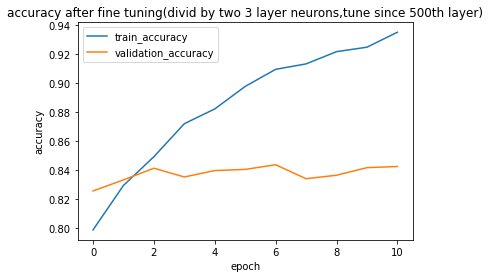

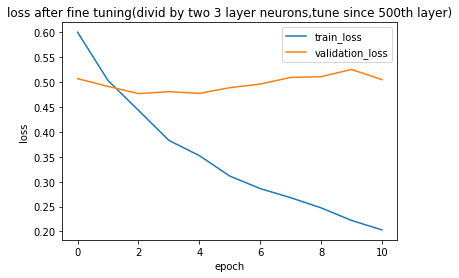

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(divid by two 3 layer neurons,tune since 500th layer)')

plot_loss(history_fine,'loss after fine tuning(divid by two 3 layer neurons,tune since 500th layer)')

#### **Now multiply the number of neurons in each layer by 2 in selected architecture that consists classifier with three layers**

## **Multiply by 2**

In [ ]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(2048,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

Epoch 1/10
468/468 [==============================] - 106s 199ms/step - loss: 1.3558 - accuracy: 0.5918 - val_loss: 0.6779 - val_accuracy: 0.7772
Epoch 2/10
468/468 [==============================] - 88s 189ms/step - loss: 0.9577 - accuracy: 0.6884 - val_loss: 0.6536 - val_accuracy: 0.7865
Epoch 3/10
468/468 [==============================] - 89s 189ms/step - loss: 0.8243 - accuracy: 0.7250 - val_loss: 0.6273 - val_accuracy: 0.7925
Epoch 4/10
468/468 [==============================] - 89s 191ms/step - loss: 0.7509 - accuracy: 0.7548 - val_loss: 0.5858 - val_accuracy: 0.8033
Epoch 5/10
468/468 [==============================] - 88s 188ms/step - loss: 0.6921 - accuracy: 0.7646 - val_loss: 0.5682 - val_accuracy: 0.8093
Epoch 6/10
468/468 [==============================] - 87s 186ms/step - loss: 0.6544 - accuracy: 0.7806 - val_loss: 0.5867 - val_accuracy: 0.8057
Epoch 7/10
468/468 [==============================] - 87s 186ms/step - loss: 0.6229 - accuracy: 0.7873 - val_loss: 0.5978 - val_a

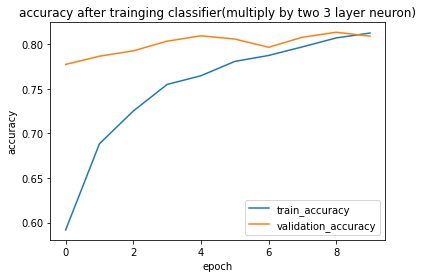

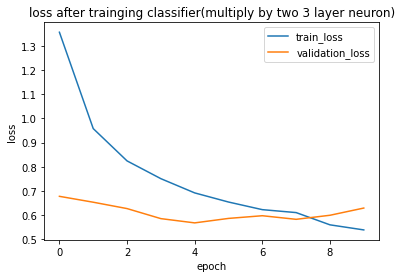

In [ ]:
plot_accuracy(history,'accuracy after trainging classifier(multiply by two 3 layer neuron)')

plot_loss(history,'loss after trainging classifier(multiply by two 3 layer neuron)')

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 105s 199ms/step - loss: 0.4430 - accuracy: 0.8415 - val_loss: 0.5943 - val_accuracy: 0.8173
Epoch 11/20
468/468 [==============================] - 90s 192ms/step - loss: 0.3698 - accuracy: 0.8756 - val_loss: 0.5700 - val_accuracy: 0.8245
Epoch 12/20
468/468 [==============================] - 90s 192ms/step - loss: 0.3058 - accuracy: 0.8972 - val_loss: 0.5967 - val_accuracy: 0.8257
Epoch 13/20
468/468 [==============================] - 89s 190ms/step - loss: 0.2614 - accuracy: 0.9118 - val_loss: 0.5701 - val_accuracy: 0.8241
Epoch 14/20
468/468 [==============================] - 89s 191ms/step - loss: 0.2361 - accuracy: 0.9206 - val_loss: 0.5613 - val_accuracy: 0.8337
Epoch 15/20
468/468 [==============================] - 89s 190ms/step - loss: 0.2129 - accuracy: 0.9260 - val_loss: 0.5633 - val_accuracy: 0.8361
Epoch 16/20
468/468 [==============================] - 89s 190ms/step - loss: 0.1879 - accuracy: 0.9368 - val_loss: 0.5878 

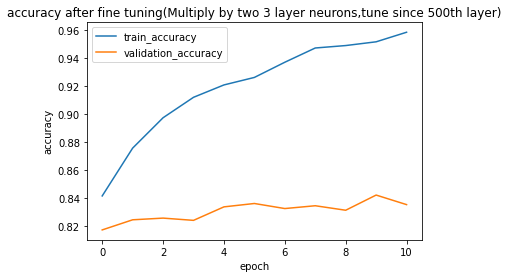

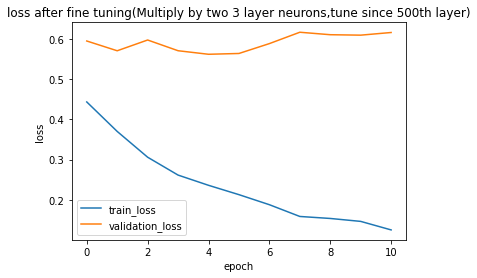

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(Multiply by two 3 layer neurons,tune since 500th layer)')

plot_loss(history_fine,'loss after fine tuning(Multiply by two 3 layer neurons,tune since 500th layer)')

### **Now as you can see when we divide number of neuron of selected architecture, validation accuracy increased a little and generalization of model also is better** 

## **how many layers should be freeze**

### **already we tune from 500th layer in fine tuning training. Now we examine other layers from which start tuning**

# **tune from 400th layer**

In [ ]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(512,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

Epoch 1/10
468/468 [==============================] - 111s 208ms/step - loss: 1.3176 - accuracy: 0.5649 - val_loss: 0.6112 - val_accuracy: 0.7973
Epoch 2/10
468/468 [==============================] - 97s 206ms/step - loss: 0.9844 - accuracy: 0.6717 - val_loss: 0.5614 - val_accuracy: 0.8081
Epoch 3/10
468/468 [==============================] - 96s 206ms/step - loss: 0.8900 - accuracy: 0.7051 - val_loss: 0.5418 - val_accuracy: 0.8089
Epoch 4/10
468/468 [==============================] - 94s 202ms/step - loss: 0.8169 - accuracy: 0.7229 - val_loss: 0.5320 - val_accuracy: 0.8145
Epoch 5/10
468/468 [==============================] - 96s 206ms/step - loss: 0.7689 - accuracy: 0.7477 - val_loss: 0.5449 - val_accuracy: 0.8089
Epoch 6/10
468/468 [==============================] - 96s 204ms/step - loss: 0.7395 - accuracy: 0.7483 - val_loss: 0.5415 - val_accuracy: 0.8109
Epoch 7/10
468/468 [==============================] - 91s 195ms/step - loss: 0.7160 - accuracy: 0.7579 - val_loss: 0.5290 - val_a

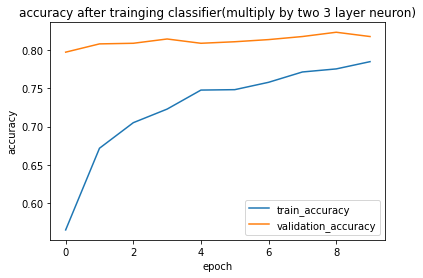

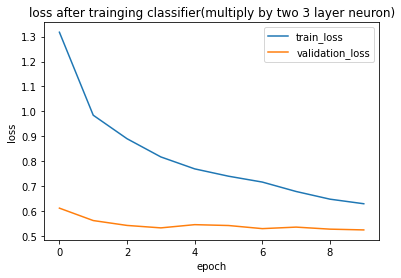

In [ ]:
plot_accuracy(history,'accuracy after trainging classifier(multiply by two 3 layer neuron)')

plot_loss(history,'loss after trainging classifier(multiply by two 3 layer neuron)')

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 112s 208ms/step - loss: 0.6606 - accuracy: 0.7777 - val_loss: 0.5364 - val_accuracy: 0.8177
Epoch 11/20
468/468 [==============================] - 93s 199ms/step - loss: 0.4886 - accuracy: 0.8352 - val_loss: 0.4997 - val_accuracy: 0.8365
Epoch 12/20
468/468 [==============================] - 95s 203ms/step - loss: 0.4188 - accuracy: 0.8589 - val_loss: 0.4742 - val_accuracy: 0.8389
Epoch 13/20
468/468 [==============================] - 96s 204ms/step - loss: 0.3593 - accuracy: 0.8771 - val_loss: 0.4958 - val_accuracy: 0.8401
Epoch 14/20
468/468 [==============================] - 94s 201ms/step - loss: 0.3138 - accuracy: 0.8959 - val_loss: 0.4746 - val_accuracy: 0.8413
Epoch 15/20
468/468 [==============================] - 94s 202ms/step - loss: 0.2843 - accuracy: 0.9065 - val_loss: 0.4790 - val_accuracy: 0.8417
Epoch 16/20
468/468 [==============================] - 95s 202ms/step - loss: 0.2373 - accuracy: 0.9246 - val_loss: 0.4970 

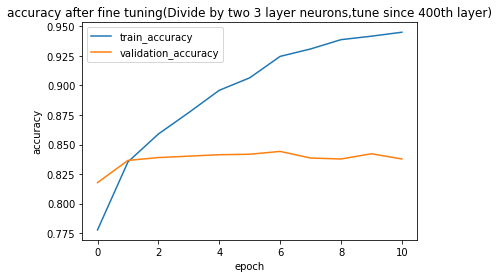

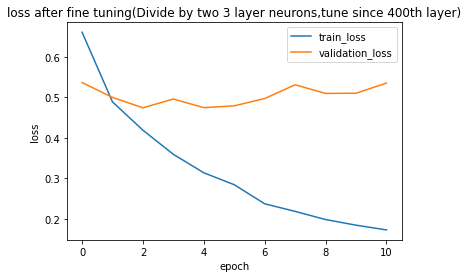

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(Divide by two 3 layer neurons,tune since 400th layer)')

plot_loss(history_fine,'loss after fine tuning(Divide by two 3 layer neurons,tune since 400th layer)')

# **tune from 550th layer**

In [ ]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(512,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [ ]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

Epoch 1/10
468/468 [==============================] - 112s 212ms/step - loss: 1.3516 - accuracy: 0.5513 - val_loss: 0.6183 - val_accuracy: 0.7853
Epoch 2/10
468/468 [==============================] - 94s 200ms/step - loss: 1.0005 - accuracy: 0.6702 - val_loss: 0.5694 - val_accuracy: 0.8029
Epoch 3/10
468/468 [==============================] - 94s 202ms/step - loss: 0.8978 - accuracy: 0.6991 - val_loss: 0.5492 - val_accuracy: 0.8121
Epoch 4/10
468/468 [==============================] - 93s 198ms/step - loss: 0.8317 - accuracy: 0.7233 - val_loss: 0.5290 - val_accuracy: 0.8213
Epoch 5/10
468/468 [==============================] - 92s 197ms/step - loss: 0.7633 - accuracy: 0.7406 - val_loss: 0.5274 - val_accuracy: 0.8161
Epoch 6/10
468/468 [==============================] - 93s 198ms/step - loss: 0.7297 - accuracy: 0.7569 - val_loss: 0.5116 - val_accuracy: 0.8229
Epoch 7/10
468/468 [==============================] - 93s 198ms/step - loss: 0.7039 - accuracy: 0.7639 - val_loss: 0.5387 - val_a

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 550

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [ ]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 109s 207ms/step - loss: 0.5765 - accuracy: 0.8012 - val_loss: 0.4823 - val_accuracy: 0.8309
Epoch 11/20
468/468 [==============================] - 94s 201ms/step - loss: 0.5154 - accuracy: 0.8255 - val_loss: 0.4727 - val_accuracy: 0.8357
Epoch 12/20
468/468 [==============================] - 93s 198ms/step - loss: 0.4656 - accuracy: 0.8435 - val_loss: 0.4623 - val_accuracy: 0.8401
Epoch 13/20
468/468 [==============================] - 92s 196ms/step - loss: 0.4250 - accuracy: 0.8588 - val_loss: 0.4759 - val_accuracy: 0.8373
Epoch 14/20
468/468 [==============================] - 93s 199ms/step - loss: 0.4019 - accuracy: 0.8645 - val_loss: 0.4848 - val_accuracy: 0.8365
Epoch 15/20
468/468 [==============================] - 92s 198ms/step - loss: 0.3679 - accuracy: 0.8723 - val_loss: 0.4722 - val_accuracy: 0.8401
Epoch 16/20
468/468 [==============================] - 94s 201ms/step - loss: 0.3491 - accuracy: 0.8793 - val_loss: 0.4858 

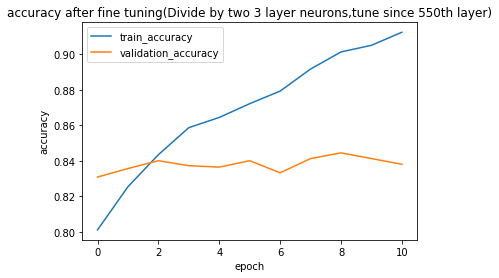

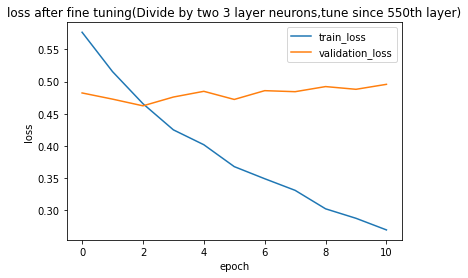

In [ ]:
plot_accuracy(history_fine,'accuracy after fine tuning(Divide by two 3 layer neurons,tune since 550th layer)')

plot_loss(history_fine,'loss after fine tuning(Divide by two 3 layer neurons,tune since 550th layer)')

#### **the best case is a model with 3 layer classifier and 512,256 and 10 layer neuron respectively in each layer of classifier and start tuning from 500th layer**

#### **Hear we want to analyze effect of learning rate on model especialy for preventing model overfitting in tuning**

### **LR: 5e-5**

In [24]:

def design_model():
  base_model = tf.keras.applications.densenet.DenseNet169(
      input_shape=(128,128,3),
      include_top=False, weights='imagenet'
      )  

  # Freezing Layers
  for layer in base_model.layers:
      layer.trainable=False


  # Building Model
  model=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(512,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return model,base_model


In [25]:
# Train the model with data from 10 classes
initial_epochs = 10

#train_classifier
model,base_model = design_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1
                    )

51888128/51877672 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
468/468 [==============================] - 110s 204ms/step - loss: 1.3940 - accuracy: 0.5424 - val_loss: 0.6149 - val_accuracy: 0.7897
Epoch 2/10
468/468 [==============================] - 91s 193ms/step - loss: 1.0248 - accuracy: 0.6609 - val_loss: 0.5574 - val_accuracy: 0.8053
Epoch 3/10
468/468 [==============================] - 99s 211ms/step - loss: 0.9061 - accuracy: 0.7023 - val_loss: 0.5273 - val_accuracy: 0.8229
Epoch 4/10
468/468 [==============================] - 98s 209ms/step - loss: 0.8528 - accuracy: 0.7119 - val_loss: 0.5256 - val_accuracy: 0.8149
Epoch 5/10
468/468 [==============================] - 96s 204ms/step - loss: 0.8034 - accuracy: 0.7313 - val_loss: 0.5076 - val_accuracy: 0.8213
Epoch 6/10
468/468 [==============================] - 95s 203ms/step - loss: 0.7597 - accuracy: 0.7397 - val_loss: 0.5174 - val_accuracy: 0.8217
Epoch 7/10
468/468 [==============================] - 95s 203ms/step - loss: 0.7159 - accuracy: 0.7606 - val_loss: 0.5150 - val_a

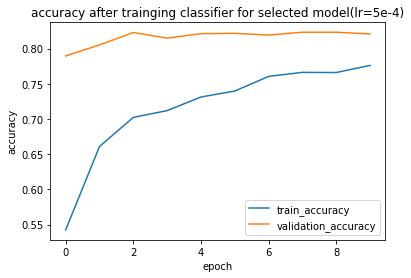

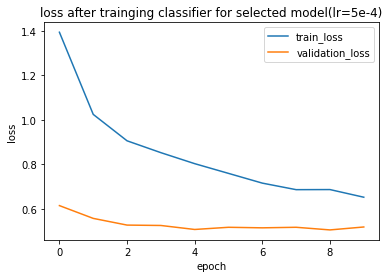

In [26]:
plot_accuracy(history,'accuracy after trainging classifier for selected model(lr=5e-4)')

plot_loss(history,'loss after trainging classifier for selected model(lr=5e-4)')

In [27]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  595


In [28]:
# Train the model with data from 10 classes
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#train_classifier
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    )

Epoch 10/20
468/468 [==============================] - 111s 208ms/step - loss: 0.6116 - accuracy: 0.7929 - val_loss: 0.5129 - val_accuracy: 0.8217
Epoch 11/20
468/468 [==============================] - 95s 203ms/step - loss: 0.5418 - accuracy: 0.8132 - val_loss: 0.4958 - val_accuracy: 0.8257
Epoch 12/20
468/468 [==============================] - 95s 202ms/step - loss: 0.4867 - accuracy: 0.8370 - val_loss: 0.4812 - val_accuracy: 0.8329
Epoch 13/20
468/468 [==============================] - 95s 202ms/step - loss: 0.4597 - accuracy: 0.8451 - val_loss: 0.4743 - val_accuracy: 0.8349
Epoch 14/20
468/468 [==============================] - 93s 200ms/step - loss: 0.4184 - accuracy: 0.8638 - val_loss: 0.4762 - val_accuracy: 0.8353
Epoch 15/20
468/468 [==============================] - 94s 201ms/step - loss: 0.3829 - accuracy: 0.8711 - val_loss: 0.4637 - val_accuracy: 0.8446
Epoch 16/20
468/468 [==============================] - 94s 201ms/step - loss: 0.3677 - accuracy: 0.8780 - val_loss: 0.4623 

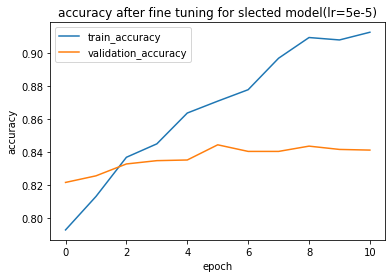

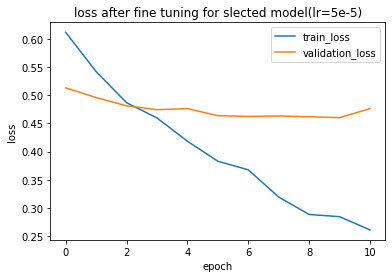

In [29]:
plot_accuracy(history_fine,'accuracy after fine tuning for slected model(lr=5e-5)')

plot_loss(history_fine,'loss after fine tuning for slected model(lr=5e-5)')

In [31]:
#test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2500 images belonging to 10 classes.


In [33]:
model.evaluate(test_generator)

157/157 [==============================] - 18s 111ms/step - loss: 0.4753 - accuracy: 0.8416


[0.47534605860710144, 0.8416000008583069]